<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC4</p>
<p style="margin: 0; text-align:right;">2019-2 · Màster universitari en Ciencia de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia y Telecomunicacions</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 4: Sèries temporals i Combinació de classificadors

Aquesta pràctica està dividida en dues parts.

 - En el primer exercici veurem com descomposar i composar sèries temporals per realitzar prediccions a futur. 
 - En el segon exercici veurem diferents mètodes de combinació de classificadors.

Per aquesta PAC s'han d'utilitzar **únicament les llibreries que s'importen a continuació**. Si es desitja utilitzar alguna altre llibreria, s'ha de consultar amb el professor/a col·laborador/a de l'aula.

**<u>Important</u>: Cada exercici pot suposar varis minuts d'execució, pel que l'entrega ha de realitzar-se en format notebook i en format html on es vegi el codi i els resultats i comentaris de cada exercici. Per exportar el notebook a html pot fer-se des del menu File $\to$ Download as $\to$ HTML.**

In [1]:
import pickle

import scipy.stats
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn import svm
from sklearn import ensemble
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline

E:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
E:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# 1. Sèries temporals (5 punts)

En aquest primer exercici treballarem les sèries temporals. Utilitzarem el dataset *AirPassangers* que conté informació del nombre de vols que es van realitzar al llarg de varis anys.

Començarem llegint les dades i observant gràficament la seva distribució. Com es pot apreciar, és un cas clar de sèrie temporal, amb heterocedasticitat, tendència, període i soroll. Al llarg d'aquest exercici tractarem cadascun d'aquests punts.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


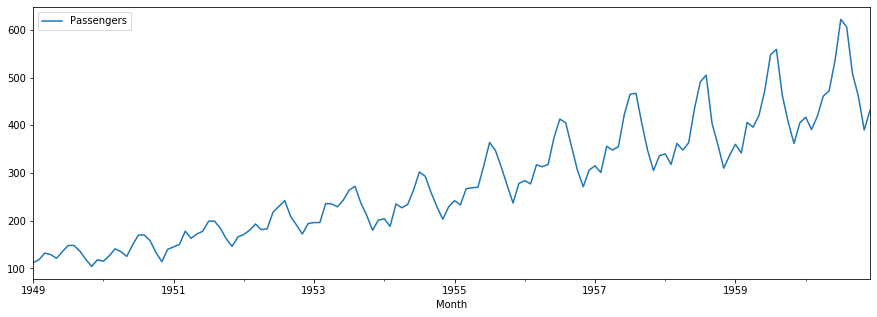

In [3]:
data.plot(figsize=(15, 5))

Abans de començar a tractar les diferents components d'una sèrie temporal, eliminarem del dataset original un parell d'anys de dades. Així quan fem una predicció a futur podrem comprovar si s'ajusta a les dades reals. 

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

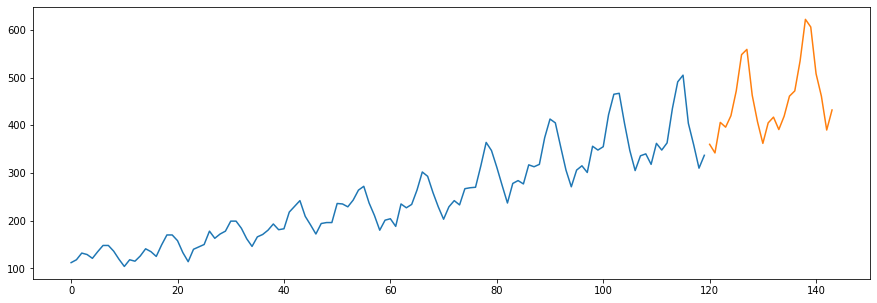

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

## 1.1 Components de la sèrie temporal

### 1.1.a. Heterocedasticitat

Es diu que una sèrie temporal té heterocedasticitat quan la variància varia amb el temps (https://es.wikipedia.org/wiki/Heterocedasticidad). En el nostre cas, observem que tenim heterocedasticitat, ja que l'amplitud de l'ona varia amb el temps. En aquest primer apartat heu d'eliminar l'heterocedasticitat de la sèrie temporal. És a dir, que la diferència entre el mínim i el màxim de l'estacionalitat (anual) sigui més o menys constant al llarg del temps.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Transformació de les dades per eliminar l'heterocedasticitat. Per fer aixo heu de transformar les dades aplicant la funció que considereu que elimina millor l'heterocedasticitat en el dataset, proveu amb les tres funcions següents: 

- exponencial
- logarítmica
- arrel quadrada
    
i decidiu quina de les tres funciona millor per eliminar l'heterocedasticitat. Aquestes funcions ja estan implementades en `numpy`. 
    
Mostreu gràficament el dataset transformat.
</div>

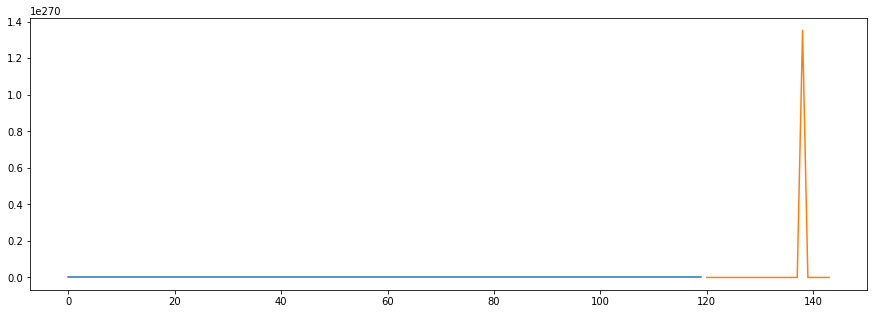

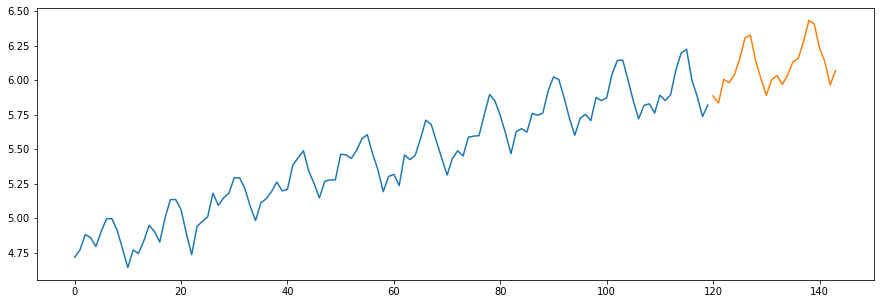

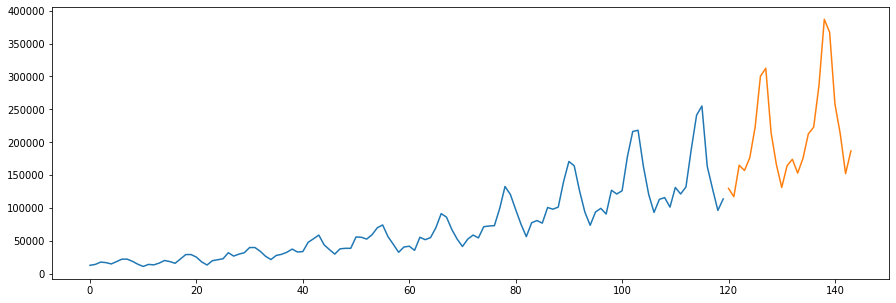

In [6]:
# exponencial
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, np.exp(train))
ax.plot(x_test, np.exp(test))
plt.show()
# logaritmica - Aconsegueix eliminar l'heterocedasticitat
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, np.log(train))
ax.plot(x_test, np.log(test))
plt.show()
# arrel quadrada
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, np.square(train))
ax.plot(x_test, np.square(test))
plt.show()

### 1.1.b. Tendència

La tendència és el comportament que tenen les dades a llarg plaç (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). A la nostra sèrie temporal tenim una tendència lineal creixent. En aquest apartat heu d'eliminar la tendència, quedant una serie temporal amb tendència constant.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Eliminar la tendència de les dades. Com que observant la sèrie podeu apreciar que tenim una tendència lineal, podeu ajustar una regresió lineal (utilitzant <i>scikit-learn</i>) i restar-la de les dades originals (sense heterocedasticitat). 
    
Mostreu gràficament les dades sense tendència.
</div>

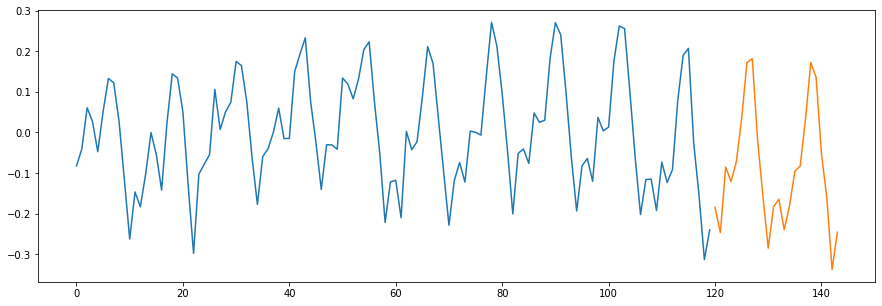

In [7]:
# fit de les regressions lineals
lrtrain= LinearRegression().fit(x_train.reshape(-1,1), np.log(train))
lrtest = LinearRegression().fit(x_test.reshape(-1,1), np.log(test))

# restem la predicció a la funció logaritmica (homocedasticitat)
d_train= np.log(train)-lrtrain.predict(x_train.reshape(-1,1))
d_test = np.log(test)-lrtrain.predict(x_test.reshape(-1,1))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, d_train)
ax.plot(x_test, d_test)
plt.show()

### 1.1.c. Estacionalitat

Definim l'estacionalitat com la variació cíclica que es produeix en les dades  (https://es.wikipedia.org/wiki/Estacionalidad). En aquest apartat s'ha de trobar i eliminar l'estacionalitat.

#### 1.1.c.a. Trobar el període de l'estacionalitat

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> En primer lloc heu de trobar el cicle, és a dir, cada quan es repeteixen les dades. Per trobar-lo podeu utilitzar l'autocorrelació (<i>numpy</i> et permet obtenir els coeficients de correlació). La idea és que s'ha de comparar:
    
- La sèrie original amb la sèrie començant en el segon punt (és a dir, serie[1:])
- La serie original amb la serie començant al tercer punt (és a dir, serie[2:])
- ...
    
En el moment en que torni a començar el cicle, la serie serà molt semblant a la sèrie original, i per tant la correlació serà molt elevada. El punt on la correlació sigui màxima, serà el cicle de la sèrie. 
    
Mostrar gràficament els coeficients dels 22 primers valors d'autocorrelació i determinar el seu valor màxim, aquestà serà la nostra estacionalitat. 
    
<u>NOTA</u>: Si utilitzeu <i>numpy</i> per trobar els coeficients de correlació, les dues sèries que compareu han de tenir la mateixa longitud. Per representar la serie original podeu eliminar valors del final perquè tingui la mateixa longitud que la sèrie "moguda". Per exemple, en el primer cas podeu comparar serie[1:] amb serie[:-1].
</div>

El coeficient d'autocorrelació per 1 és 0.6863670843761102
El coeficient d'autocorrelació per 2 és 0.24118928605834225
El coeficient d'autocorrelació per 3 és -0.11223687835356673
El coeficient d'autocorrelació per 4 és -0.3618983682828931
El coeficient d'autocorrelació per 5 és -0.3829254494755654
El coeficient d'autocorrelació per 6 és -0.3510364643347255
El coeficient d'autocorrelació per 7 és -0.37907570487847486
El coeficient d'autocorrelació per 8 és -0.3548787405298607
El coeficient d'autocorrelació per 9 és -0.11279566504383941
El coeficient d'autocorrelació per 10 és 0.20158460153843621
El coeficient d'autocorrelació per 11 és 0.596661799000912
El coeficient d'autocorrelació per 12 és 0.8777294256508061
El coeficient d'autocorrelació per 13 és 0.5877082939559259
El coeficient d'autocorrelació per 14 és 0.1468935287628172
El coeficient d'autocorrelació per 15 és -0.1707280134862342
El coeficient d'autocorrelació per 16 és -0.4150191577855602
El coeficient d'autocorrelació per 1

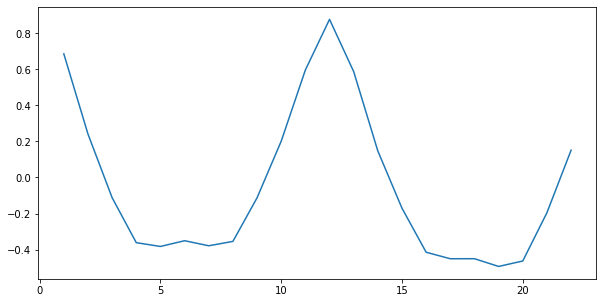

In [8]:
x=[]
y=[]
for i in range(1,23):
    a= np.array(d_train.Passengers.transpose())[i:]
    b= np.array(d_train.Passengers.transpose())[:-i]
    print("El coeficient d'autocorrelació per {0} és {1}".format(i,np.corrcoef(a,b)[0,1]))
    x.append(i)
    y.append(np.corrcoef(a,b)[0,1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x,y)
plt.show()

#### 1.1.c.b. Aplicar un model SARIMA

Per tractar l'estacionalitat aplicarem un model SARIMA. Les sigles corresponen a "stationality ARIMA", és a dir, un model ARIMA amb estacionalitat (la que acabem de trobar). 

El model ARIMA ens permetrà tractar el soroll que queda al eliminar l'heterocedasticitat, tendència i estacionalitat. Per fer-ho té en compte les següents components:

- AR: auto-regressive, es denomina *p*. Té en compte la correlació amb els seus lags, és a dir, mira si les observacions passades afecten a l'hora de calcular el punt següent.
- I: integrated, es denomina *d*. Això és l'ordre de diferenciació, en el nostre cas no és necessari, ja que la sèrie ja no té ni heterocedasticitat ni tendència.
- MA: moving-average, es denomina *q*. Té en compte la correlació amb els lags dels errors, és a dir, un cop aplicat el model mira els errors del model versus les dades reals.
  
Per més informació sobre els ARIMA podeu consultar aquest link: https://otexts.com/fpp2/arima.html

Els models SARIMA depenen de varis paràmetres (p,d,q)(P,D,Q)s, on els primers (minúscules) corresponen a AR, I, MA de la sèrie normal, i els segons (majúscules) a AR, I, MA amb estacionalitat. 

Per trobar aquests paràmetres hem de mirar els gràfics PACF (<i>partial autocorrelation function</i>) i ACF (<i>autocorrelation function</i>).

El gràfic PACF ens determina el paràmetre *p*, és a dir, l'AR.

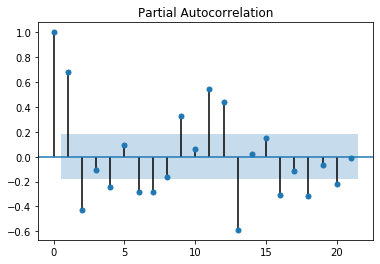

In [9]:
# Suposem que les dades sense heterocedasticitat ni tendència es diuen train_log_trend
plot_pacf(d_train)
plt.show()

Per llegir aquest gràfic, simplement ens hem de fixar en els valors que surten fora de l'interval de confiança (zona blava). 

Només començar hi ha dos valors fora de l'interval. De totes maneres, el primer no conta, ja que el primer mira la correlació d'un amb si mateix, per tant sempre serà 1. Si no tenim en compte el primer, només hi ha un valor fora de l'interval de confiança, per tant **p = 1**.

Quan es repeteix el cicle, és a dir, a partir del valor 11, tornen a haver-hi dos valors fora de l'interval, per tant **P = 2**.

Anem a veure ara el gràfic ACF, aquest ens determinara el valor de *q*.

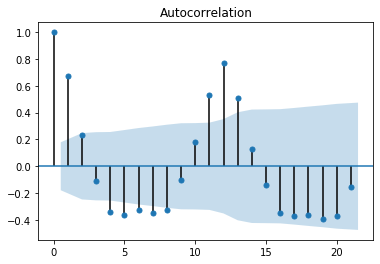

In [10]:
# Suposem que les dades sense heterocedasticitat ni tendència es diuen train_log_trend
plot_acf(d_train)
plt.show()

Aquest gràfic es llegeix igual que l'anterior. 
Només començar hi ha un valor fora de l'interval, per tant **q = 1**.
Quan es repeteix el cicle, és a dir, a partir del valor 11, hi han tres valors fora de l'interval, per tant **Q = 3**.

Com que les dades no tenen ni tendència ni heterocedasticitat, **d = D = 0**.

Com hem vist a l'apartat anterior, el cicle és 12, per tant **s = 12**.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Aplica un model SARIMA a les dades sense heterocedasticitat ni tendència. Pots utilitzar SARIMAX (de <i>statsmodels.tsa.statespace.sarimax</i>) amb els paràmtres que acabem de veure. 
    
Mostrar gràficament el resultat del model juntament amb la sèrie original per comparar si s'ajusta bé.
</div>

E:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
E:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
E:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


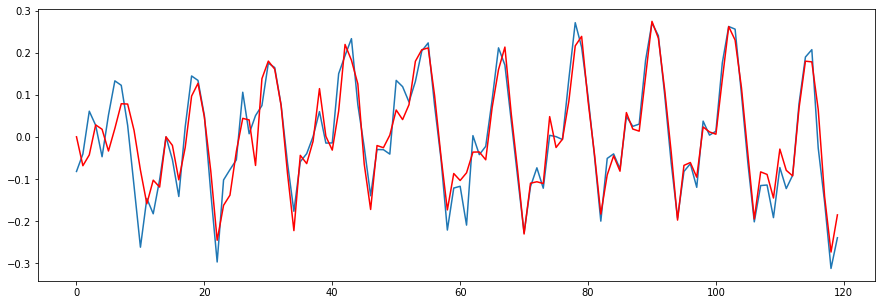

In [11]:
# valors de les variables
p,P = 1,2
q,Q = 1,3
d,D = 0,0
s=12

# fit del model
sarma= SARIMAX(np.array(d_train.Passengers), order=(p,d,q), seasonal_order=(P,D,Q,s))
sarma= sarma.fit()
#print(sarmafit.summary())

# comparació gràfica
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, d_train)
plt.plot(sarma.fittedvalues, color='r')
plt.show()

## 1.2. Predicció

Anem a predir els dos pròxims anys i comparar la predicció amb les dades reals. Seguirem els següents passos:

   - Generar la predicció amb el SARIMA
   - Afegir tendència
   - Afegir heterocedasticitat

### 1.2.a. Preddicció SARIMA

Utilitzarem el model SARIMA que hem fitat abans per predir els pròxims dos anys.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Genera dos anys de dades mitjançant el model SARIMA fitat a l'apartat anterior.

Grafica tota la sèrie (sense heterocedasticitat ni tendència), diferenciant amb colors diferents la sèrie real dels dos anys de predicció.
</div>

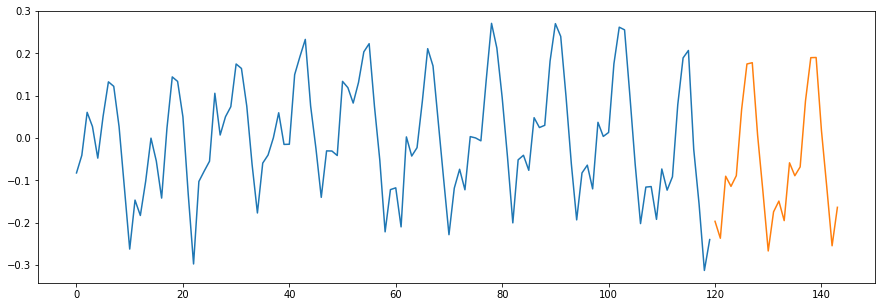

In [12]:
# fem la predicció per 24 mesos a partir del final de train (inclòs)
pred= sarma.predict(len(x_train),len(x_train)+23)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, d_train)
ax.plot(x_test, pred)
plt.show()

### 1.2.b. Tendència

Anteriorment hem vist que les dades de la sèrie temporal tenen una tendència lineal i la hem calculat mitjançant una regressió lineal. Afegirem aquesta tendència a la nostra predicció.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Afegir a la sèrie anterior, la tendència trobada a l'apartat 1.1.b.

Mostra gràficament tota la sèrie (sense heterocedasticitat), diferenciant amb colors diferents la sèrie real dels dos anys de predicció.
</div>

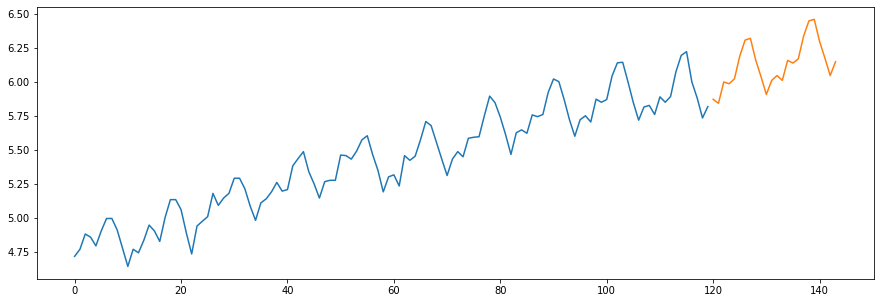

In [13]:
# afegim a la predicció la tendència calculada per a train
predt= pred.reshape(-1,1) + lrtrain.predict(x_test.reshape(-1,1))
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, np.log(train))
ax.plot(x_test, predt)
plt.show()

### 1.2.c. Heterocedasticitat

En el primer apartat d'aquesta pràctica hem vist que la sèrie temporal té heterocedasticitat i l'hem eliminat transformant les dades. En aquest apartat farem la transformació inversa per afegir heterocedasticitat a la nostra predicció.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Afegir a la sèrie calculada a l'apartat anterior, l'heterocedasticitat aplicant la funció inversa a la trobada a l'apartat 1.1.a.
    
Mostra gràficament tota la sèrie, diferenciant amb colors diferents la sèrie real dels dos anys de predicció. 
</div>

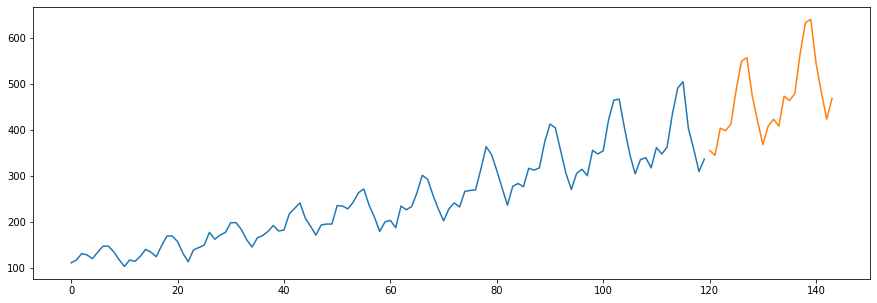

In [14]:
# invertim la funció log amb exp i obtenim la predicció inicial
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, np.exp(predt))
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Afegeix al gràfic anterior la serie real pels dos anys de predicció.
</div>

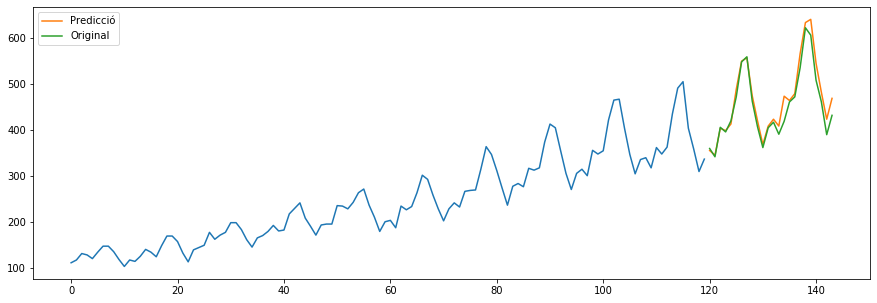

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, np.exp(predt), label='Predicció')
ax.plot(x_test, test, label='Original')
plt.legend(loc='upper left')
plt.show()

## 2. Combinació de clasificadors (5 punts)

Per aquest exercici utilitzarem el dataset *cars.csv*. Aquest dataset conté dades sobre proves fetes en un model de cotxe, en concret s'estudia si el cotxe derraparà o no en una curva en funció de la velocitat que porta. El dataset conté les següent columnes:

  - speed: velocitat que porta el cotxe
  - angle: angle de la curva
  - succeed: 1 si el cotxe agafa la curva sense problemes, 0 si el cotxe derrapa

A la primera part d'aquest exercici veurem la combinació de classificadors en paral·lel mitjançant les tècniques de **_Bagging_** i **_Boosting_**.

La segona part preten millorar els resultats aplicant tècniques de combinació seqüencial de classificadors: **_Stacking_** i **_Cascading_**.

En primer lloc, anem a visualitzar el dataset.

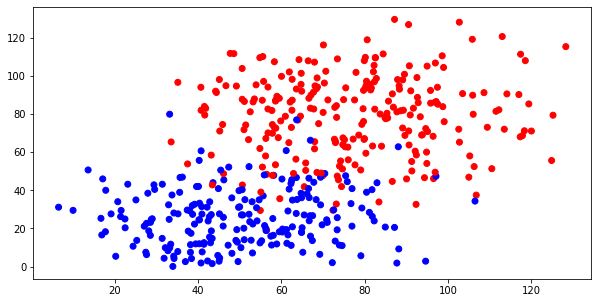

In [16]:
cars = pd.read_csv('cars.csv')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.scatter(cars['speed'], cars['angle'], c = cars['succeed'], cmap = 'bwr')

Per tal de provar diferents models, en primer lloc cal dividir el dataset entre train i test. 

Perquè tots obtingueu els mateixos resultats i poder comentar dubtes pel forum, fixarem la seed per obtenir els mateixos datasets de train i test. 

Com que en aquest exercici tractarem *stacking* i *cascading*, i ambdos s'apliquen sobre el conjunt de test, farem un *split* del 50% per tenir una mica més de base al aplicar aquestes dues tècniques.

In [17]:
X = cars.drop(columns = 'succeed')
y = cars['succeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 34)

Per visualitzar gràficament com funcionen els diferents models, dibuixarem les fronteres de decisió. El que ens interessa és veure la forma que tenen (si és quadriculada, suau, ...), i si hi ha zones d'indecisió (areas blanquinoses). La idea és entendre perquè el model que apliquem té aquestes característiques. 

Per dibuixar les fronteres podeu utilitzar la següent funció.

In [18]:
# Fem la meshgrid amb els valors màxim i mínim de 'x' i 'y'.
x_min, x_max = X['speed'].min()-0.1, X['speed'].max()+0.1
y_min, y_max = X['angle'].min()-0.1, X['angle'].max()+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=1):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predim el classifier amb els valors de la meshgrid.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Fem reshape per tenir el format correcte.
    Z = Z.reshape(xx.shape)

    # Seleccionem una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = mpl.colors.ListedColormap(arr)
    
    # Fem el gràfic de les fronteres de decisió.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap)

    # Afegim els punts.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

## 2.1. Combinació paral·lela de classificadors

### 2.1.1. Arbre de decisió

Per poder comparar l'augment de *performance* obtingut a mida que anem aplicant tècniques noves, utilitzarem com a *baseline* un simple arbre de decisió.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un arbre de decisió sobre el conjunt de dades de train amb profunditat màxima de 3 nivells (aplicarem la mateixa restricció en les següents seccions).
    
A continuació, avalua sobre test i calcula la seva precisió aplicant validació creuada amb 5 conjunts. 
    
Finalment, dibuixa la frontera de decisió.

<u>Suggerència</u>: utilitzar el mòdul *cross_val_score* de *sklearn*. Per apendre més sobre *cross validation* i sobre com utilitzar aquests mòduls, us recomanem els següents enllaços:
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

CV amb 5 conjunts sobre train: [0.91489362 0.91304348 0.93478261 0.89130435 0.91304348]
Score sobre test: 0.9181034482758621


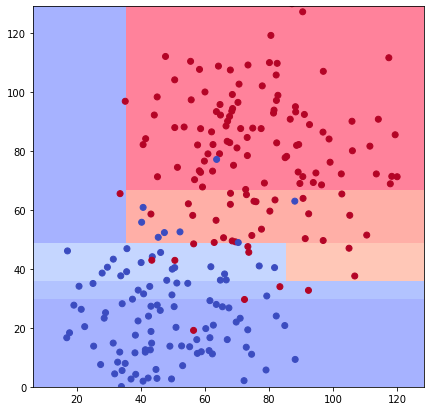

In [19]:
dtc= DecisionTreeClassifier(max_depth=3,random_state=34)
dtc.fit(X_train, y_train)
dtc_cvl= cross_val_score(dtc, X_train, y_train, cv=5)
dtc_sco= dtc.score(X_test, y_test)
print('CV amb 5 conjunts sobre train: {0}\nScore sobre test: {1}'.format(dtc_cvl, dtc_sco))
plot_decision_boundaries(X_test.speed, X_test.angle, y_test, dtc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i, en especial, la frontera de decisió.
</div>

- Tal com era d'esperar donat el scatter plot original, trobem dos espais de decisió ben definits per les caracteristiques linies i angles rectes que formen les fronteres dels arbres de decisió. La part vermella es troba a la meitat superior dreta i la part blava a la resta.
- Com que limitem la profunditat a 3 no es dona repetició -tenim una sola regió vermella i una sola blava- pero a canvi sí trobem algunes àrees d'indecisió, concretament a la franja mitjana del graf, on l'algoritme reconeix una probablitat menor d'encertar la predicció tot marcant-les amb un color menys intens.
- En tot cas la precisió és bastant encertada (91.81%), resultat que també és d'esperar ja que el conjunt de dades és molt senzill (només dos atributs) i amb un objectiu binari clarament diferenciat en la majoria de casos (exceptuant com hem vist l'àrea de superposició a la franja mitjana). Per tant un arbre de decisió resulta un excelent clasificador per aquest problema concret.

### 2.1.2.a. *Bagging*

La idea bàsica del *bagging* és utilitzar el conjunt d'entrenament original per generar centenar o milers de conjunts similars utilitzant mostreig amb remplaçament. L'algorisme *random forest* està basat en aquest concepte, la combinació de varis arbres de decisió, cadascun entrenat amb una mostra diferent de les dades. La decisió final del classificador combinat (la *random forest*) es pren per majoria, donant el mateix pes a totes les decisions parcials preses pels classificadors base (els arbres).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un <i>random forest</i> sobre el conjunt de dades de train amb profunditat màxima de 3 nivells i 20 arbres.
    
A continuació, avalua sobre test i calcula la seva precisió aplicant validació creuada amb 5 conjunts.
    
Finalment, dibuixa la frontera de decisió.

<u>Suggerència</u>: utilitzar el mòdul *RandomForestClassifier* de *sklearn*. Per apendre a utilitzar aquest mòdul us recomanem el següent enllaç::
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

CV amb 5 conjunts sobre train: [0.95744681 0.91304348 0.93478261 0.91304348 0.91304348]
Score sobre test: 0.9137931034482759


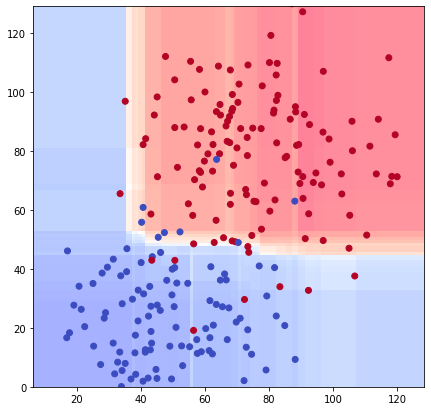

In [20]:
rfc= ensemble.RandomForestClassifier(max_depth=3, n_estimators=20, random_state=34)
rfc.fit(X_train, y_train)
rfc_cvl= cross_val_score(rfc, X_train, y_train, cv=5)
rfc_sco= rfc.score(X_test, y_test)
print('CV amb 5 conjunts sobre train: {0}\nScore sobre test: {1}'.format(rfc_cvl, rfc_sco))
plot_decision_boundaries(X_test.speed, X_test.angle, y_test, rfc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i, en especial, la frontera de descisió.
</div>

- Aquí podem veure el resultat de l'aplicació de 20 arbres que, en paralel, seleccionen com a entrada subconjunts de les dades originals. El resultat pel que fa a les àrees de decisió blava/vermella és molt similar a l'anterior, però el major número d'arbres fa que les probabilitats quedin molt més definides. Això genera un número molt superior de seccions que arriben a patir de indecisió a les parts més controvertides (estretes i amb color molt pàlid), situades sempre en el limit entre les dues zones de decisió.
- Pel que fa a la precisió obtinguda resulta molt semblant a la del arbre individual, com era d'esperar per aquest cas.

### 2.1.3. *Boosting*

En el sistema de *Boosting* es combinen varis classificadors dèbils seqüencialment, i en cadascun d'ells es dona més pes a les dades que han sigut erròniament classificades en les combinacions anteriors, perquè es concentri així en els casos més difícils de resoldre.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un <i>gradient boosting</i> sobre el conjunt de dades de train amb profunditat màxima de 3 nivells i 20 arbres.
    
A continuació, avalua sobre test i calcula la seva precisió aplicant validació creuada amb 5 conjunts.
    
Finalment, dibuixa la frontera de decisió.

<u>Suggerència</u>: utilitzar el mòdul *GradientBoostingClassifier* de sklearn. Per apendre a utilitzar aquest mòdul us recomanem el següent enllaç:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

CV amb 5 conjunts sobre train: [0.91489362 0.93478261 0.95652174 0.89130435 0.91304348]
Score sobre test: 0.9094827586206896


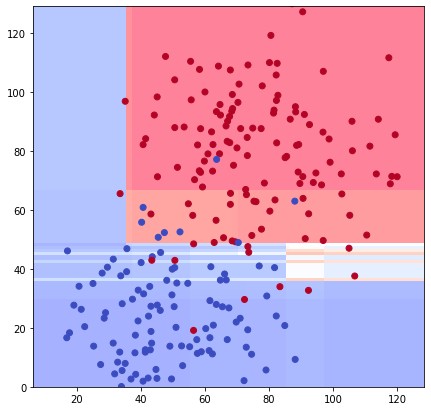

In [21]:
gbc= ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20, random_state=34)
gbc.fit(X_train, y_train)
gbc_cvl= cross_val_score(gbc, X_train, y_train, cv=5)
gbc_sco= gbc.score(X_test, y_test)
print('CV amb 5 conjunts sobre train: {0}\nScore sobre test: {1}'.format(gbc_cvl, gbc_sco))
plot_decision_boundaries(X_test.speed, X_test.angle, y_test, gbc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i, en especial, la frontera de decisió.
</div>

- Gradient boosting també es basa en arbres de decisió i per tant manté un esquema similar als dos anteriors, amb àrees de decisió delimitades per linies i angles rectes.
- En aquest cas el filtre sequencial de resultats i la seva atenció especial als casos més dificils de resoldre genera algunes irregularitats en la franja més conflictiva, on trobem un àrea de indecisió (blanca) creuada per tres àrees estretes  de vermell que interfereixen també amb l'àrea de decisió blava (repetició).
- Això afecta finalment a la precisió, que baixa més d'un punt respecte a l'arbre de decisió.

## 2.2. Combinació seqüencial de classificadors base diferents

Per poder fer combinació seqüencial de models, necessitem tenir varis models diferents entrenats. 

En el nostre cas, ja tenim un arbre de decisió. Anem a entrenar un parell de models més.

### 2.2.1 KNN (k veïns més propers)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un <i>k-neighbors</i> amb 2 veïns sobre el conjunt de dades de train. 

A continuació, Avalua sobre test i calcula la seva precisió aplicant validació creuada amb 5 conjunts.
    
Finalment, dibuixa la frontera de decisió.
</div>  

CV amb 5 conjunts sobre train: [0.89361702 0.89130435 0.95652174 0.82608696 0.89130435]
Score sobre test: 0.8706896551724138


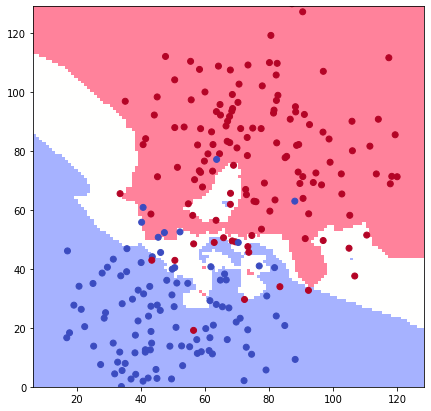

In [22]:
knc= KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)
knc_cvl= cross_val_score(knc, X_train, y_train, cv=5)
knc_sco= knc.score(X_test, y_test)
print('CV amb 5 conjunts sobre train: {0}\nScore sobre test: {1}'.format(knc_cvl, knc_sco))
plot_decision_boundaries(X_test.speed, X_test.angle, y_test, knc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

- Knn genera tres àrees de decisió dividides en vermell, blau i blanc (indecís). Les fronteres en aquest cas no són linies rectes ja que es calculen segons proximitat als n punts més propers (2 en aquest cas).
- Podem veure que l'àrea d'indecisió és bastant ampla, sobretot als costats, on comença a allunyar-se dels dos clusters principals i troba equidistància entre ells. La part central està més disputada, amb una major mescla de punts de totes dues classes, fet que provoca illes d'indecisió tant a la part vermella com a la blava, i a la vegada genera petites àrees de valor contrari dins d'elles.
- Aquesta frontera poc definida (clusters amb molts àrea comuna) causa una caiguda de la precisió respecte als anteriors models fins al 87%

### 2.2.2 SVM (Suport vector machines)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un SVM amb gamma = 0.07 sobre el conjunt de dades de train.

A continuació, avalua sobre test i calcula la seva precisió aplicant validació creuada amb 5 conjunts.
    
Finalment, dibuixa la frontera de decisió.
    
<u>NOTA</u>: perquè funcioni la funció de les fronteres de decisió s'ha d'especificar "probability=True" al inicialitzar el model.
</div>  

CV amb 5 conjunts sobre train: [0.74468085 0.73913043 0.91304348 0.84782609 0.86956522]
Score sobre test: 0.8836206896551724


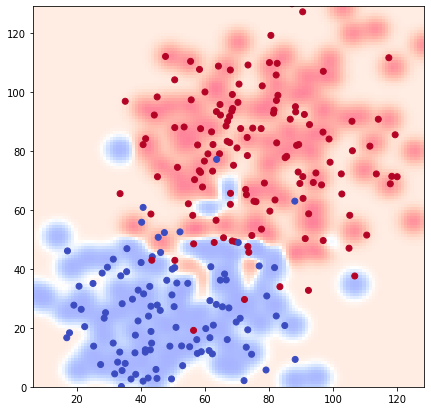

In [23]:
svc= svm.SVC(gamma=0.07, probability=True)
svc.fit(X_train, y_train)
svc_cvl= cross_val_score(svc, X_train, y_train, cv=5)
svc_sco= svc.score(X_test, y_test)
print('CV amb 5 conjunts sobre train: {0}\nScore sobre test: {1}'.format(svc_cvl, svc_sco))
plot_decision_boundaries(X_test.speed, X_test.angle, y_test, svc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

- En aquest cas el classificador SVM utilitza l'estatègia radial per defecte, i podem veure la clara tendència a fer cercles per delimitar les àrees de decisió, els quals s'uneixen per formar les zones més clarament identificades.
- La transició directa entre les àrees blava i vermella passa per una estreta linia de indecisió blanca on les probabilitats es reparteixen entre les dues classes.
- La precisió resultant sobre test millora respecte a knn però no arriba a la dels arbres.

### 2.2.1 *Stacking*

Un classificador de *stacking* utilitza com a atributs les prediccions fetes per altres classificadors en comptes de les dades originals d'entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Construeix un classificador de <i>stacking</i> utilitzant un <i>Gradient Boosting</i> (amb 20 arbres de decisió i profunditat màxima 3 nivells) que utilitzi com a atributs les prediccions fetes en el conjunt de test pels algoritmes: 
    
- arbre de decisió
- knn
- svm 
    
Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test (en aquest cas no tenim conjunt de train, per tant es fa directament cross validation sobre test).

<u>Suggerència</u>: utilitzar la funció column_stack de numpy per ajuntar totes les prediccions. Per apendre a utilitzar aquesta funció us recomanem el següent enllaç:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
</div>

In [24]:
X_sta= np.column_stack((dtc.predict(X_test),knc.predict(X_test),svc.predict(X_test)))
gbc_sta= ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20, random_state=34)
gbc_sta.fit(X_sta, y_test)
gbc_sta_cvl= cross_val_score(gbc_sta, X_sta, y_test, cv=5)
gbc_sta_sco= gbc_sta.score(X_sta, y_test)
print('CV amb 5 conjunts: {:0.2f} (+/- {:0.2f}) _ {}\nScore: {}'.format
      (gbc_sta_cvl.mean(), gbc_sta_cvl.std(), gbc_sta_cvl, gbc_sta_sco))

CV amb 5 conjunts: 0.92 (+/- 0.04) _ [0.9787234  0.91489362 0.86956522 0.93478261 0.89130435]
Score: 0.9224137931034483


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Anàlisi:</strong> Has aconseguit millorar la precisió gràcies al <i>stacking</i>? Comenta els resultats.
</div>

- La precisió millora respecte als test de cadascun dels models originals per separat, és a dir, mitjançant les decisions parcials adoptades en paralel pels tres classificadors previs hem generat un nou conjunt de dades adient per resoldre el problema. Tot i que el resultat encara és molt similar al de l'arbre de decisió simple. 

## 2.2.2. *Cascading*

El cas del *cascading* és similar al del *stacking* però utilitzant no només les prediccions parcials dels classificadors base, sinó també les dades originals.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Construeix un classificador de <i>cascading</i> utilitzant un <i>Gradient Boosting</i> (amb <b>20 arbres</b> de decisió i <b>profunditat màxima de 3</b> nivells) que utilitzi com a atributs a les prediccions obtingudes amb els models anteriors en el conjunt de test (igual que amb el <i>stacking</i>), i també les variables originals. 
    
Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test.

<u>Suggerència</u>: Utilitza el mateix conjunt de dades que a l'exercici anterior però afegeix `X_test`.
</div>

In [25]:
X_cas= np.column_stack((X_test,X_sta))
gbc_cas= ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20, random_state=34)
gbc_cas.fit(X_cas, y_test)
gbc_cas_cvl= cross_val_score(gbc_cas, X_cas, y_test, cv=5)
gbc_cas_sco= gbc_cas.score(X_cas, y_test)
print('CV amb 5 conjunts: {:0.2f} (+/- {:0.2f}) _ {}\nScore: {}'.format
      (gbc_cas_cvl.mean(), gbc_cas_cvl.std(), gbc_cas_cvl, gbc_cas_sco))

CV amb 5 conjunts: 0.94 (+/- 0.04) _ [1.         0.89361702 0.93478261 0.95652174 0.89130435]
Score: 0.978448275862069


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Anàlisi:</strong> Has aconseguit millorar la precisió gràcies al <i>cascading</i>? Comenta els resultats.
</div>

- En aquest cas reunim ja 5 atributs rellevants que, en combinació amb un boosting que prengui especial atenció als valors dificils de decidir, aconsegueixen millorar notablement (fins casi un 98%) la precisió del model.